# Pipeline: Regression Models

## 1. Introduction

Ten years' worth of AstraZeneca Adjusted Close price data will be used to see if it possible to forecast out 'n' days in the future. Fourteen models will be compared to see whether Gradient-Descent Based, Distance-Based or Tree-Based algorithms perform best.

After a spot check of the models the best performing will be selected and Grid Search cross validation will then be used to find the best parameters for tuning the models, and visualising the results.




## 2. Install/import libraries

In [ ]:
!pip install yfinance

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

%matplotlib inline

# Import the models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
# from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')


## 3. Import data
Ten years of AstraZeneca stock data will be downloaded from Yahoo! Finance using the yfinance API.

In [72]:
azn_df = yf.download("AZN.L", start="2013-01-01", end="2023-10-10")[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)

[*********************100%%**********************]  1 of 1 completed


Text(0, 0.5, 'Stock price')

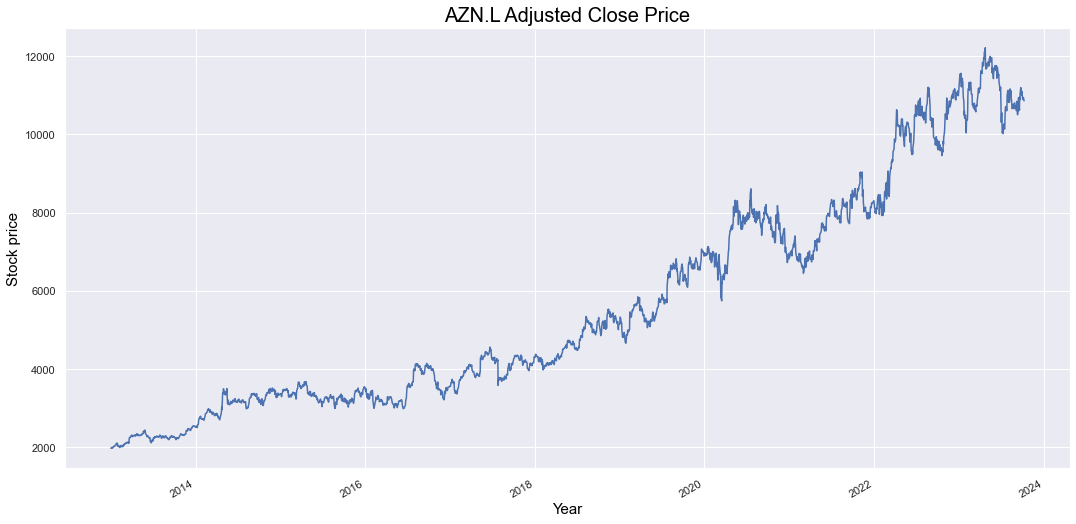

In [74]:
# Plot Adjusted Close price
azn_df['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(18, 9)})
plt.title('AZN.L Adjusted Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15)

In [75]:
# Create Dataframe for Adjusted Close prices

azn_adj = azn_df[['Adj Close']]
azn_adj.head()

,Adj Close
Date,
2013-01-02,1974.84
2013-01-03,1982.16
2013-01-04,1995.46
2013-01-07,1985.48
2013-01-08,1995.46


## 4. Feature engineering
The Adjusted Close price will be shifted 'n' days in the future to create a column of prices for prediction.

In [76]:
# A variable for predicting 'n' days into the future

forecast_out = 30

# Create column for target variable shifted 'n' days up
azn_adj['Prediction'] = azn_adj[['Adj Close']].shift(-forecast_out)

azn_adj.head()

,Adj Close,Prediction
Date,,
2013-01-02,1974.84,2043.79
2013-01-03,1982.16,2028.20
2013-01-04,1995.46,2034.09
2013-01-07,1985.48,2017.47
2013-01-08,1995.46,2042.75


## 5. Splitting the data

The last 'n' rows will be removed as these rows are NaNs in the Prediction column (y variable). 

In [77]:
X = np.array(azn_adj.drop(columns = ['Prediction']))
# Remove last 'n' rows
X = X[:-forecast_out]

print(X)

[[ 1974.84]
 [ 1982.16]
 [ 1995.46]
 ...
 [10770.  ]
 [10750.  ]
 [10660.  ]]


In [78]:
y = np.array(azn_adj['Prediction'])
# Remove last 'n' rows
y = y[:-forecast_out]

print(y)

[ 2043.79  2028.2   2034.09 ... 10902.   10942.   10856.  ]


The data will be split into training and test sets.

In [79]:
train_size = int(X.shape[0] * 0.7)

X_train = X[0:train_size]
y_train = y[0:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

In [80]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1883, 1)
(1883,)
(808, 1)
(808,)


In [81]:
print(X_train)
print(y_train)

[[1974.84]
 [1982.16]
 [1995.46]
 ...
 [7761.59]
 [7643.37]
 [7574.1 ]]
[2043.79 2028.2  2034.09 ... 8128.24 8082.06 7990.63]


The last 'n' days of the Adjusted Close price will be saved as an array.

In [82]:
X_forecast = np.array(azn_adj.drop(columns = ['Prediction']))[-forecast_out:]

## 6. Evaluate algorithms

A dictionary of models will be created to spot check using default parameters, and select the best performing ones for tuning.

In [83]:
models = {}
models["Linear"] = LinearRegression()
models["Lasso"] = Lasso()
models["Ridge"] = Ridge()
models["ElasticNet"] = ElasticNet()
models["KNN"] = KNeighborsRegressor()
models["DecisionTree"] = DecisionTreeRegressor()
models["SVR"] = SVR(kernel='rbf', C=1e3, gamma='scale')
models["AdaBoost"] = AdaBoostRegressor()
models["GradientBoost"] = GradientBoostingRegressor()
models["RandomForest"] = RandomForestRegressor()
models["ExtraTrees"]= ExtraTreesRegressor()
models["BaggingRegressor"] = BaggingRegressor()
# models["XGBRegressor"] = XGBRegressor(objective ='reg:squarederror')
models["MLPRegressor"] = MLPRegressor(solver = 'lbfgs')

###  Spot check algorithms



To avoid look-ahead bias we will use sklearn's TimeSeriesSplit class so that models are not trained on data they have already seen. 



In [84]:
model_results = []  
model_names   = []
for model_name in models:
    model = models[model_name]
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=7)
    
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    model_results.append(cv_results)
    model_names.append(model_name)
    print("{}: {}, ({})".format(model_name, round(cv_results.mean(), 6), round(cv_results.std(), 6)))

Linear: -0.261716, (0.464163)
Lasso: -0.261802, (0.464329)
Ridge: -0.261716, (0.464164)
ElasticNet: -0.261789, (0.464305)
KNN: -1.429361, (1.195657)
DecisionTree: -1.498254, (1.309527)
SVR: -5.160488, (4.616956)
AdaBoost: -1.63264, (1.305731)
GradientBoost: -1.329077, (1.316074)
RandomForest: -1.416149, (1.300122)
ExtraTrees: -1.438216, (1.330654)
BaggingRegressor: -1.407708, (1.279137)
MLPRegressor: -0.057288, (0.381682)


### Boxplot to compare regression models

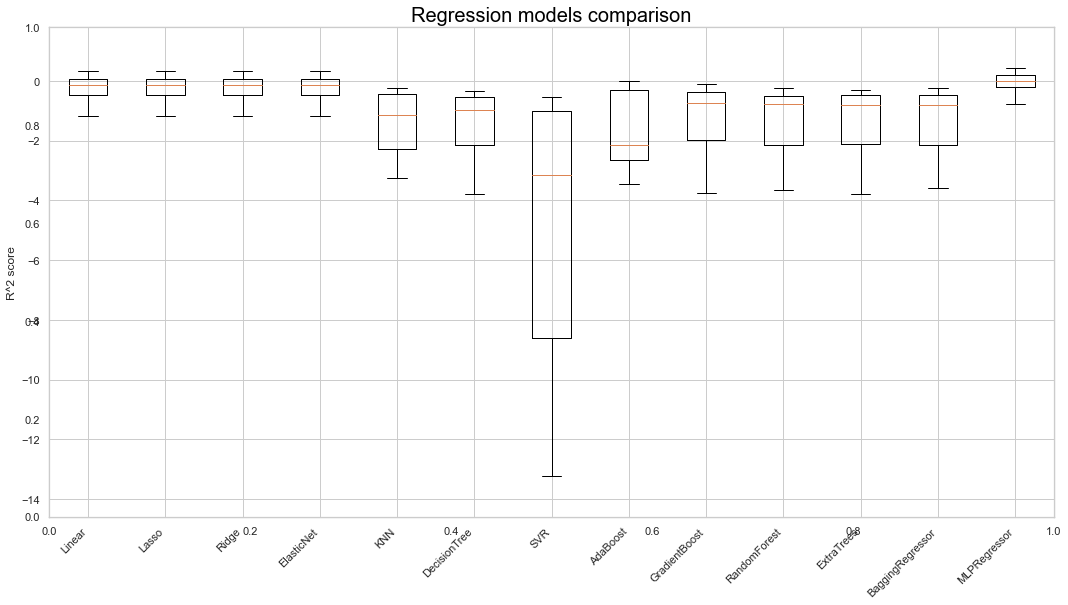

In [85]:
# Compare algorithms  

def box_compare():
    sns.set(rc={'figure.figsize':(18, 9)})
    sns.set_style(style='whitegrid', )
    figure = plt.figure()
    plt.title('Regression models comparison', color = 'black', fontsize = 20)
    axis = figure.add_subplot(111)
    plt.boxplot(model_results)
    axis.set_xticklabels(model_names, rotation = 45, ha="right")
    axis.set_ylabel("R^2 score")
    plt.margins(0.05, 0.1)

box_compare()

The performance scores and box plots show that the linear models and the neural network perform the best. We will select Linear Regression and the MLP Regressor. Both are Gradient-Descent based models, although one is linear and the other non-linear.

## 7. Modelling

We will create, train, test and tune Linear Regression and MLP Regressor models.

### 7.1 Create, train and predict on Linear Regression model

We will look at the Linear Regression model first. It adopts a linear approach to modelling the relationship between a dependent variable and independent variable(s), and is also the simplest form of machine learning.









In [86]:
# Create Linear Regression model
lr = LinearRegression()

# Train the model
lr.fit(X_train, y_train)

LinearRegression()

In [87]:
# Make predictions using the model
predictions = lr.predict(X_test)

### Print performance metrics
The performance metric R<sup>2</sup>, or the coefficient of determination, tells us how much variance in the target variable is explained by our model. Values can range from 0 to 1. In general higher values are better, indicating that a model is highly predictive.

In [88]:
# The coefficients
print('Coefficients: ', lr.coef_)
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(y_test, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(y_test, predictions), 3)))

Coefficients:  [1.01363162]
RMSE: 633.03
R^2 score: 0.84


The R<sup>2</sup> score tells us that 81% of the variation in y can be explained by the dependence on X. 

### Visualise predicted vs actual prices

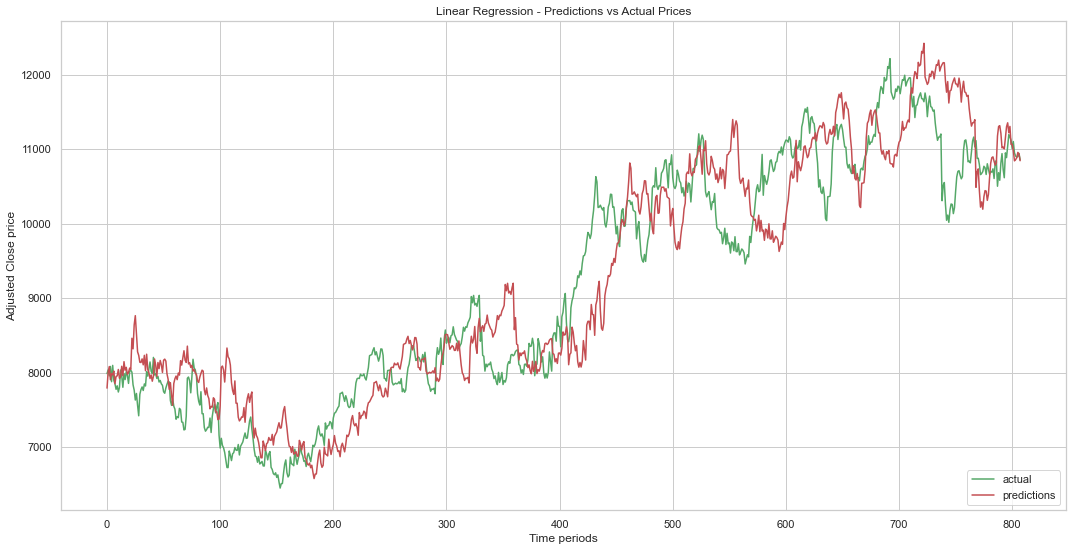

In [89]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, y_test, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

### Create DataFrame of actual vs predicted prices

In [90]:
pd.DataFrame({"Actual": y_test, "Predict": predictions}).head()

,Actual,Predict
0,7986.93,7791.763325
1,8034.96,8007.078955
2,7956.46,8081.033519
3,8082.06,7903.161441
4,7877.95,7986.481961


### Scatterplot

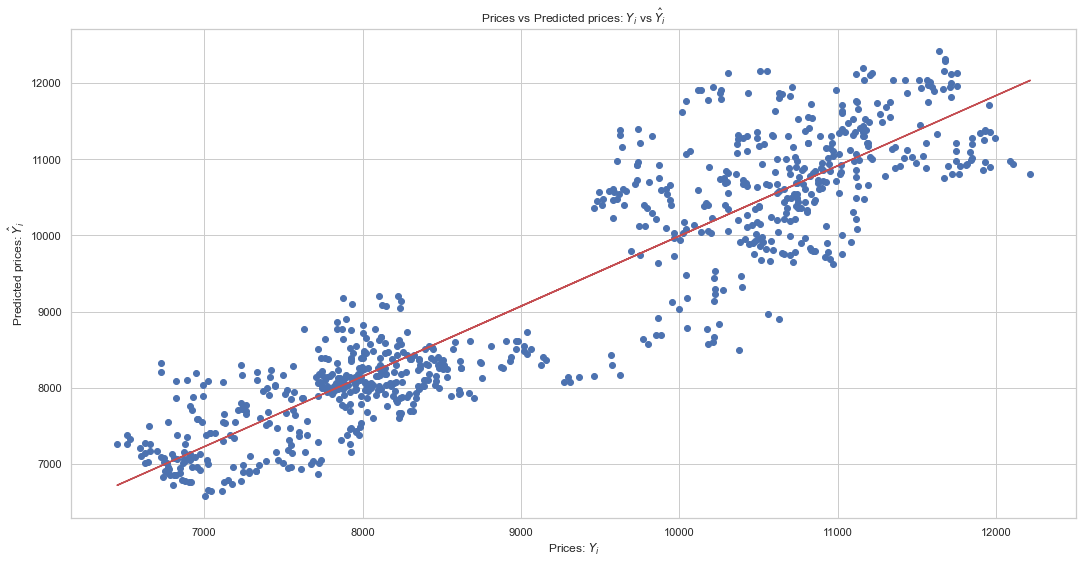

In [91]:
# create basic scatterplot
plt.scatter(y_test,predictions)

# obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(y_test, predictions, 1)

# add linear regression line to scatterplot 
plt.plot(y_test, m*y_test+b, c='r')

plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
plt.show()

### Predict next 30 days 

We will test the model on the X_forecast data and compare predictions with actual prices.

In [92]:
# Predicted prices

lr_prediction = lr.predict(X_forecast)
print(lr_prediction)

[10990.79486953 10919.84065579 10846.85917881 10885.37718055
 10875.2408643  10921.86791904 10790.09580782 11011.06750202
 11033.36739777 10684.67811885 10869.15907456 10765.76864883
 11000.93118578 11128.6487705  10913.75886605 10800.23212407
 11138.78508674 11073.91266276 11236.09372272 11386.11120319
 11355.70225444 11309.0751997  11195.54845773 11292.85709371
 11138.78508674 11096.2125585  11079.99445251 11090.13076876
 11130.67603375 11043.50371402]


### Print performance metrics

In [94]:
# The coefficients
print('Coefficients: ', lr.coef_)
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, lr_prediction, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, lr_prediction), 3)))

Coefficients:  [1.01363162]
RMSE: 187.384
R^2 score: -0.14


### Visualise predicted vs actual prices





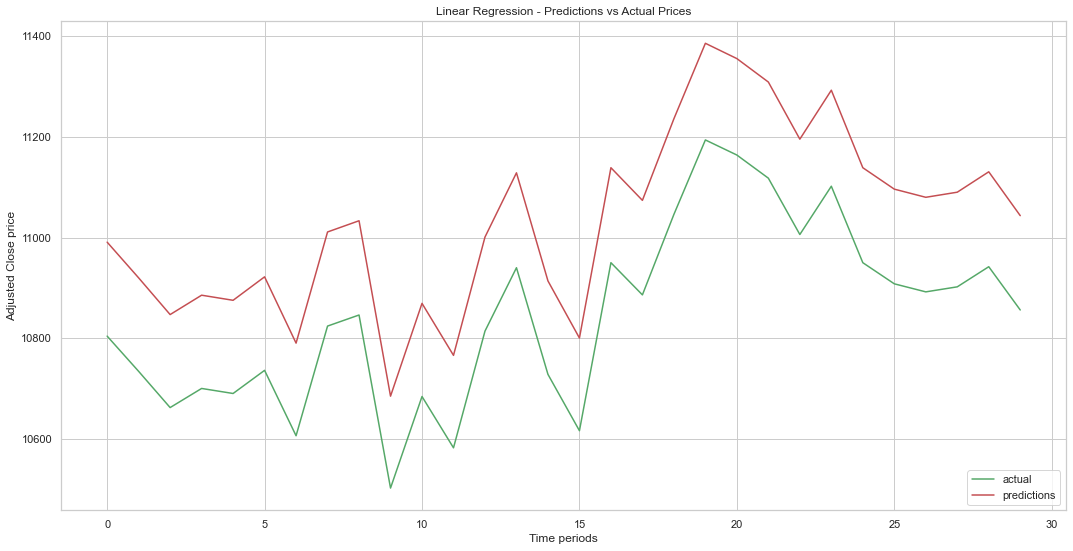

In [104]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, lr_prediction.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, lr_prediction, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

### 7.2 Create and train MLP Regressor model

The Multi-Layer Perceptron (MLP) Regressor model from scikit-learn is a class of feedforward neural network. We will create and train the model for 500 iterations using the 'lbfgs' solver which is more suited to smaller data sets and can converge faster and perform better than stochastic solvers like 'sgd' and 'adam' which work well on relatively large datasets (with thousands of training samples or more).

In [108]:
# Create an MLP Regressor model  
mlpr = MLPRegressor(max_iter=500, solver = 'lbfgs')

# Train the model using the training sets
mlpr.fit(X_train, y_train)
mlpr

MLPRegressor(max_iter=500, solver='lbfgs')

In [109]:
# Make predictions using the model
predictions = mlpr.predict(X_test)

### Print performance metrics

In [110]:
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(y_test, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(y_test, predictions), 3)))

RMSE: 640.749
R^2 score: 0.836


The R<sup>2</sup> score tells us that 83% of the variation in y can be explained by the dependence on X.

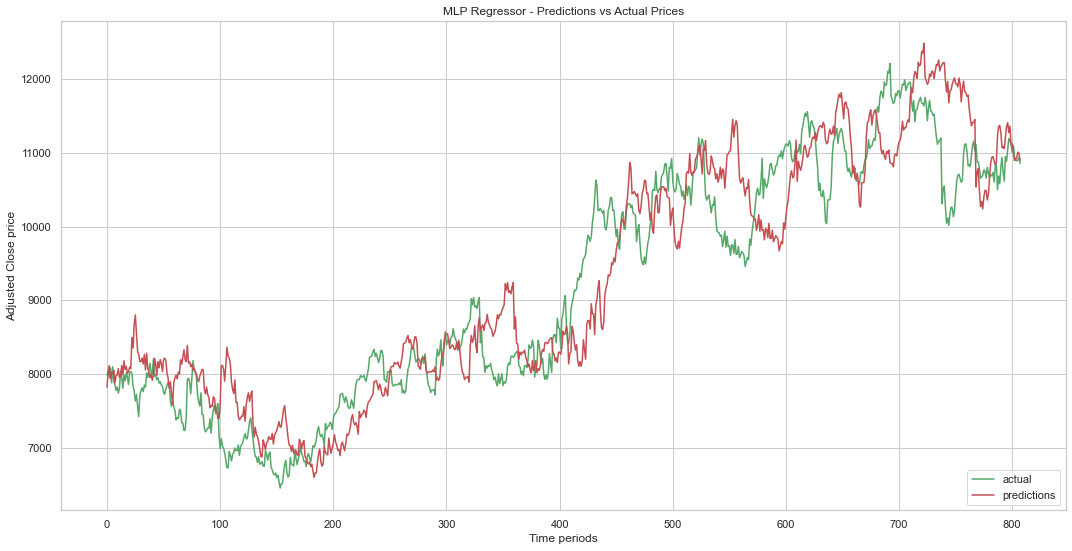

In [111]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, y_test, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('MLP Regressor - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

### Create DataFrame of actual vs predicted prices

In [50]:
pd.DataFrame({"Actual": y_test, "Predict": predictions}).head()

,Actual,Predict
0,7986.93,7819.459877
1,8034.96,8036.642632
2,7956.46,8111.238497
3,8082.06,7931.823989
4,7877.95,8015.867029


### Scatterplot

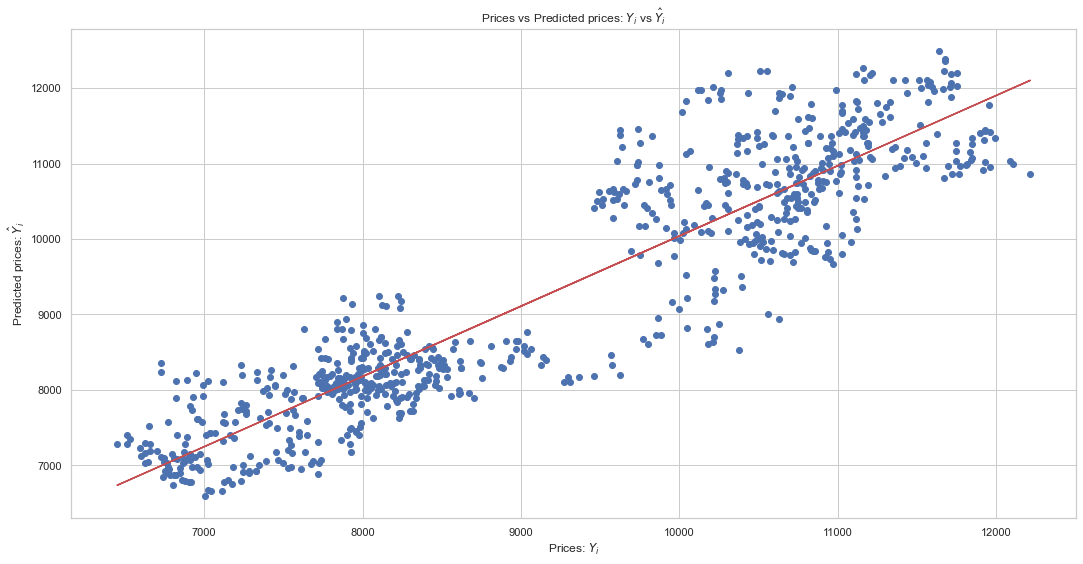

In [51]:
# create basic scatterplot
plt.scatter(y_test,predictions)

# obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(y_test, predictions, 1)

# add linear regression line to scatterplot 
plt.plot(y_test, m*y_test+b, c='r')

plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
plt.show()

### Predict next 30 days 

We will test the model on the X_forecast data and compare predictions with actual prices.

In [52]:
# Predicted prices

mlpr_prediction = mlpr.predict(X_forecast)
print(mlpr_prediction)

[11046.23205625 10974.66255788 10901.0482167  10939.9002301
 10929.67601605 10976.70740069 10843.792618   11066.68048436
 11089.17375528 10737.46079184 10923.54148761 10819.25450427
 11056.45627031 11185.28136738 10968.52802945 10854.01683205
 11195.50558143 11130.07061149 11293.65803635 11444.97640434
 11414.30376218 11367.27237753 11252.76118013 11350.91363505
 11195.50558143 11152.56388241 11136.20513992 11146.42935398
 11187.32621019 11099.39796933]


### Print performance metrics

In [113]:
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, mlpr_prediction, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, mlpr_prediction), 3)))

RMSE: 243.209
R^2 score: -0.921


### Visualise predicted vs actual prices

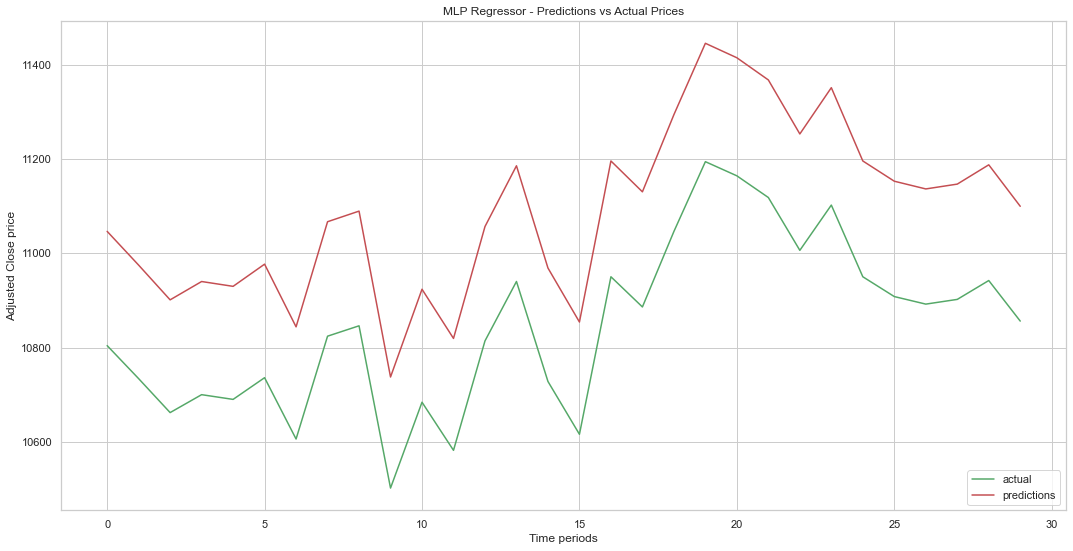

In [112]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, mlpr_prediction.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, mlpr_prediction, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('MLP Regressor - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

#### Create DataFrame of actual vs predicted prices

In [56]:
# Reshape data to be 1D
X_forecast = X_forecast.reshape(-1)

In [57]:
pd.DataFrame({"Actual": X_forecast, "Predict": mlpr_prediction}).head()

,Actual,Predict
0,10804.0,11046.232056
1,10734.0,10974.662558
2,10662.0,10901.048217
3,10700.0,10939.900230
4,10690.0,10929.676016


### Feature scaling
Multi-layer Perceptron is sensitive to feature scaling. We will normalise the training data before model fitting by converting values to a common scale. Scikit-Learn’s MinMaxScaler() function scales the data to values between 0 and 1 which helps boost performance. This is useful for optimisation algorithms and used in the core of machine learning algorithms like gradient descent. It is also useful for algorithms that weight inputs, like regression and neural networks.

In [58]:
# Reshape data as this needs to be 2D
y_train = y_train.reshape(-1, 1)

In [59]:
# Normalise data to improve convergence

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_norm = scaler.fit_transform(X_train)
y_train_norm = scaler.transform(y_train)
X_test_norm = scaler.transform(X_test)

### Create, train and test tuned model

In [123]:
# Reshape data to be 2D
X_forecast = X_forecast.reshape(-1,1)

In [124]:
# Create MLP Regression model  
mlpr = MLPRegressor(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.05, max_fun=15000, max_iter= 500,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.3, verbose=False,
             warm_start=False)

# Train the model using the training sets
mlpr.fit(X_train, y_train)

# Make predictions using the model
predictions = mlpr.predict(X_forecast)

# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, predictions), 3)))

RMSE: 243.078
R^2 score: -0.919


### Visualise predicted vs actual prices of tuned model

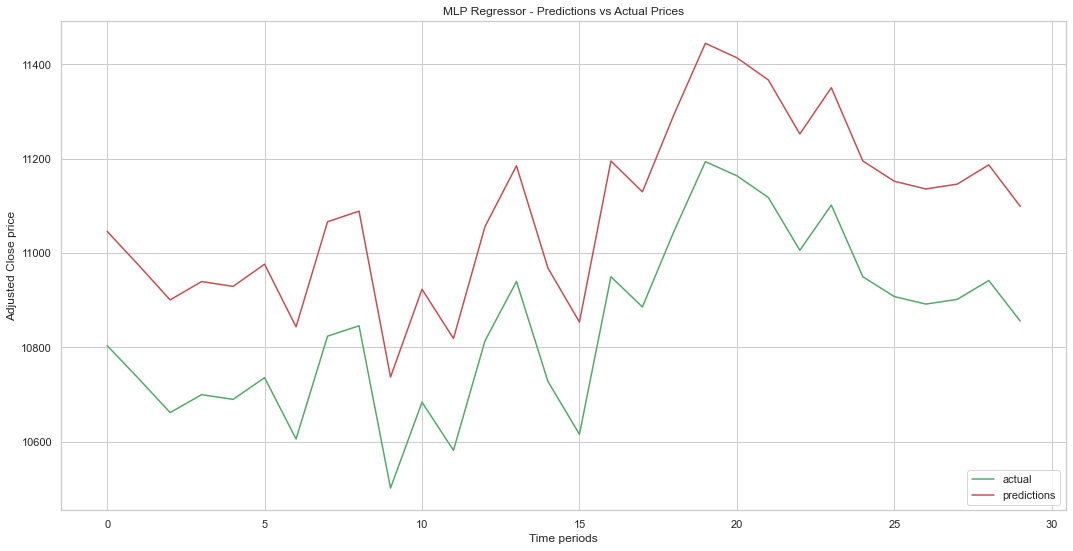

In [125]:
# Plot predictions against actual Adjusted Close prices

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('MLP Regressor - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()